# 10. Gyakorlat: Visszacsatolásos neurális hálózatok
---
## RNN hálózatok 
### Könyvtárak

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

2023-11-26 18:55:19.710691: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-26 18:55:19.738001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 18:55:19.738027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 18:55:19.738850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 18:55:19.742856: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Shakespeare adathalmaz letöltése
shakespeare = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text = open(shakespeare, 'rb').read().decode(encoding='utf-8')

print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


### Karakterek kódolása beágyazóvektorokba

In [3]:
# Tokenizálás: karakterek kódolása
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts([text])

# Szöveg átalakítása integerek szekvenciájává
encoded = np.array(tokenizer.texts_to_sequences([text])[0])

### Adatállomány előkészítése a tanításra

In [4]:
# Adathalmaz előkészítése a tanításra
seq_length = 40  # Input szekvencia hossza
features = []
labels = []
for i in range(0, len(encoded) - seq_length):
    features.append(encoded[i : i + seq_length])
    labels.append(encoded[i + seq_length])

### Transzformáció

In [5]:
# Numpy tömbbé alakítás
features = np.array(features)
labels = np.array(labels)

# Címkék 1-hot kódolása
labels_encoded = tf.keras.utils.to_categorical(labels, num_classes=len(tokenizer.word_index) + 1)

### Modellezés
#### Tanítás

In [6]:
# Modell architektúra
model = Sequential([
    Embedding(
        input_dim = len(tokenizer.word_index) + 1, 
        output_dim = 50, 
        input_length = seq_length
    ),
    SimpleRNN(128, return_sequences = False),
    Dense(len(tokenizer.word_index) + 1, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modell tanítás
n_epochs = 10
batch_size = 128
model.fit(
    features, 
    labels_encoded, 
    epochs = n_epochs, 
    batch_size = batch_size
)

Epoch 1/10
8714/8714 [==============================] - 77s 9ms/step - loss: 1.9691 - accuracy: 0.4183
Epoch 2/10
8714/8714 [==============================] - 82s 9ms/step - loss: 1.6765 - accuracy: 0.4958
Epoch 3/10
8714/8714 [==============================] - 82s 9ms/step - loss: 1.6092 - accuracy: 0.5131
Epoch 4/10
8714/8714 [==============================] - 83s 10ms/step - loss: 1.5767 - accuracy: 0.5211
Epoch 5/10
8714/8714 [==============================] - 86s 10ms/step - loss: 1.5568 - accuracy: 0.5258
Epoch 6/10
8714/8714 [==============================] - 86s 10ms/step - loss: 1.5447 - accuracy: 0.5287
Epoch 7/10
8714/8714 [==============================] - 86s 10ms/step - loss: 1.5342 - accuracy: 0.5312
Epoch 8/10
8714/8714 [==============================] - 85s 10ms/step - loss: 1.5262 - accuracy: 0.5330
Epoch 9/10
8714/8714 [==============================] - 85s 10ms/step - loss: 1.5463 - accuracy: 0.5280
Epoch 10/10
8714/8714 [==============================] - 91s 10ms/s

#### Predikció

In [7]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += output_word
    return seed_text

# Új szöveg generálása
print(generate_text("To be, or not to be, ", 50, model, seq_length))

1/1 [==============================] - 0s 11ms/step
To be, or not to be, the present the present the present the present th


---
## LSTM hálózatok
### Adathalmaz betöltése és előfeldolgozás

In [8]:
# Shakespeare adathalmaz betöltése
text = open(shakespeare, 'rb').read().decode(encoding='utf-8')

# Egyedi karakter -> index leképezés létrehozása
vocab = sorted(set(text))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

# Minden szöveg leképezése integerekké
text_as_int = np.array([char2idx[c] for c in text])
examples_per_epoch = len(text)//(seq_length + 1)
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

### Modell 

In [9]:
# Kötegméret és memória méret
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Szókincs hossza karakterekben
vocab_size = len(vocab)

# Beágyazás dimenziója
embedding_dim = 256

# RNN egységek száma
rnn_units = 1024

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            vocab_size, 
            embedding_dim,
            batch_input_shape = [batch_size, None]
        ),
        tf.keras.layers.LSTM(
            rnn_units,
            return_sequences = True,
            stateful = True,
            recurrent_initializer = 'glorot_uniform'
        ),
        tf.keras.layers.Dense(
            vocab_size
        )
    ])
    return model

model = build_model(
    vocab_size = len(vocab), 
    embedding_dim = embedding_dim, 
    rnn_units = rnn_units, 
    batch_size = BATCH_SIZE
)

### Modell tanítása

In [10]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

# Modell mentési pontok ide fognak mentésre kerülni
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Modell tanítása
EPOCHS = 10  # Tanítási időszakok száma
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
425/425 [==============================] - 151s 353ms/step - loss: 2.4015
Epoch 2/10
425/425 [==============================] - 150s 353ms/step - loss: 1.7733
Epoch 3/10
425/425 [==============================] - 144s 338ms/step - loss: 1.5909
Epoch 4/10
425/425 [==============================] - 144s 337ms/step - loss: 1.5048
Epoch 5/10
425/425 [==============================] - 143s 337ms/step - loss: 1.4510
Epoch 6/10
425/425 [==============================] - 144s 338ms/step - loss: 1.4125
Epoch 7/10
425/425 [==============================] - 144s 338ms/step - loss: 1.3807
Epoch 8/10
425/425 [==============================] - 144s 337ms/step - loss: 1.3524
Epoch 9/10
425/425 [==============================] - 144s 338ms/step - loss: 1.3254
Epoch 10/10
425/425 [==============================] - 144s 338ms/step - loss: 1.3001


In [11]:
def generate_text(model, start_string):
    num_generate = 1000

    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

# Modell betöltése 1-es kötegmérettel
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

# Szöveg generálása
print(generate_text(model, start_string=u"ROMEO:"))

ROMEO:Xj333XxWxJX3$VJK$JzKQQxKKJj3Vzxjzj3JMQQM&qJ$JxzX&$zxzzJ3K3&zH&XXxjZ&zjzMxQxxZjzxz&3xzzzJ$KJjJzXJXzjzFxjzQxzzQQxzj3zzzJ&K&&JzzzzQzXQ3zJJ$KQJJKJKKxxxXQKzX&Q$Qx&XKKKJVKQKQxj3Gzz33&X&$z3Qxzz$zQzQz3D3KzQQ$&zJzzJxzJJQ3x&xzPQzZxzXJ$$z$3Jxzzjz3Qz&zXzJ3zJVVQ$zz$xJJ3$ZjzJzHZQVzzJ3$z3z$z3zVxzz$QJJ$zzQ$z$QJQxx&zzJzzzzx3GJzJKj&qx&zxKzz$zQQzz$QKJHJ$xzzJzjXzJQQxzjz$zJjJXJzzzX&xKX$zKzzQJxXJzJKqz3x&zzQJKQJxzzxJQKzQXK&xXzQJJQ$zzQKJxX$JANzJQ3zQQ$Jz$QK&zz&x&J$JJJzzDJzJz3zJ3$JXzj33x$QK3&QzzKJK&QxQx$JYJzJjQXK$&3zzzz&3$QxMXzxXzzQKQ3$x$QQ3zQ$jKQK$Xz&XzQx$ZxzQKzKzQ$Kz$z3$KKJK3ZQQQZ$$zHzz3zzJxzzJz3zDz3QK$QzzQQ$z3$3QQ$zz33$CzzzQQ&&zK$$qxJJx&zzXZzXz&zzJJ&zjzQxzzz3Z3$3X$z$zQJ3QKSQ3SzzzJQKQKzJJ3KKx$333zz$qzz3XzJ$ZzQQZQQZzz$J3$xzzJ3zzzQJ$$zK&3xxzX$j3&ZJ$QQxzzz$zQx&QKz3xJxXJXxJQj3$zJKKzzz&Qzj3KzQ3&$zzzJxQK$QJJQ$zQzQK$J$zzQzJQKKxzQXzKZ3zJK3$x$JQK$QQ$zzK&zjz3$xzz$Xz3zzzzJzzj3Q$JJzzJxQZjQ&$zKzzJVX$zJQ3KQxjz3JVZxzzjQ3$QK$KJ3$x$JzYjz&Q&$K3zDJ3Z&xz$zQxz33zQJxXjzzJQ$JJXQ$JKzzQ$zzx3zz&Kj$z$zzVzzKQzzXz3PQQ3zX$zzJJz3J&$Q

---
# LSTM hálózatok idősorelemzésre
## Adatok szerkesztése
### Betöltés és tisztítás
Adatforrás: https://archive.ics.uci.edu/dataset/360/air+quality

In [12]:
# Adathalmaz beolvasása
df = pd.read_csv('./air+quality/AirQualityUCI.csv', sep=';', parse_dates=['Date'], decimal=',')
# Sorok és oszlopok törlése ahol csak NaN értékek vannak
df.dropna(axis=0, how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)
# Sorokon és oszlopokon belül lévő nan értékek kezelése
df.replace(-200, np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
# Dátum és idő értékek összeolvasztása egyetlen oszloppá
df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)
df['Datetime'] = df['Date'] + ' ' + df['Time']
df['Datetime'] = pd.to_datetime(df['Datetime'], format="%d/%m/%Y %H.%M.%S")
df.drop('Date', axis=1, inplace=True)
df.drop('Time', axis=1, inplace=True)
# Felesleges változó eldobása (túl sok esetben nincs adat)
df.drop('NMHC(GT)', axis=1, inplace=True)
# Index beállítása
df.set_index(['Datetime'], inplace=True)
df.head(2)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255


### Ábrázolás

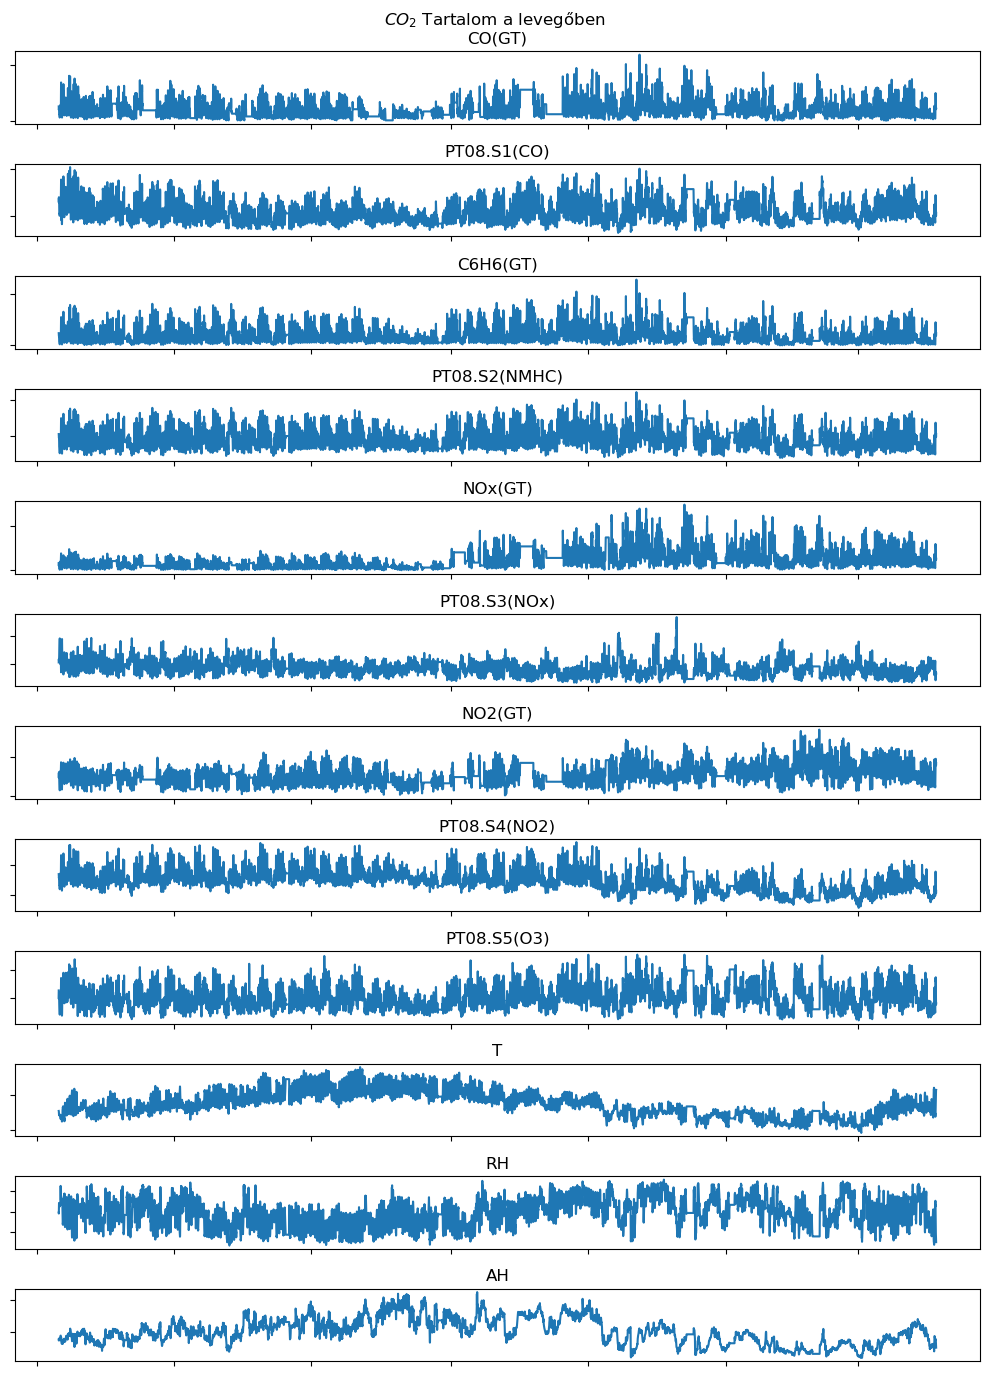

In [13]:
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 14))
plt.suptitle(r'$CO_2$ Tartalom a levegőben')
for i,x in enumerate(list(df.columns)):
    axes[i].set_title(x)
    axes[i].plot(df.index, df[x])
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

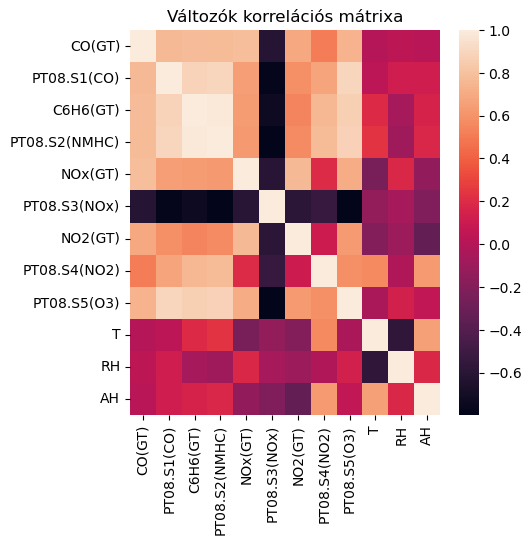

In [14]:
plt.figure(figsize=(5, 5))
plt.title('Változók korrelációs mátrixa')
sns.heatmap(df.corr())
plt.show()

### Tanító-teszt szétválasztás

In [15]:
target = 'CO(GT)'
train_time = int(len(df) * 0.6)
train = df.iloc[:train_time, :]
test = df.iloc[train_time:, :]

X_train = train.drop(target, axis=1)
y_train = train.loc[:, target]
X_test = test.drop(target, axis=1)
y_test = test.loc[:, target]

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)


X_train: (5614, 1, 11)
y_train: (5614,)
X_test: (3743, 1, 11)
y_test: (3743,)


## Modellezés
### Architektúra

In [16]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))  # return_sequences=True minden köztes LSTM réteghez
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))  # Nincs return_sequences az utolsó LSTM rétegben
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Tanítás

Epoch 1/20
81/81 - 3s - loss: 2.7973 - val_loss: 1.9909 - 3s/epoch - 42ms/step
Epoch 2/20
81/81 - 0s - loss: 1.3248 - val_loss: 1.8698 - 240ms/epoch - 3ms/step
Epoch 3/20
81/81 - 0s - loss: 1.2303 - val_loss: 1.7233 - 235ms/epoch - 3ms/step
Epoch 4/20
81/81 - 0s - loss: 1.1959 - val_loss: 1.8087 - 223ms/epoch - 3ms/step
Epoch 5/20
81/81 - 0s - loss: 1.1264 - val_loss: 1.5247 - 229ms/epoch - 3ms/step
Epoch 6/20
81/81 - 0s - loss: 1.0896 - val_loss: 1.5182 - 213ms/epoch - 3ms/step
Epoch 7/20
81/81 - 0s - loss: 0.9853 - val_loss: 1.2410 - 218ms/epoch - 3ms/step
Epoch 8/20
81/81 - 0s - loss: 1.1001 - val_loss: 1.4749 - 240ms/epoch - 3ms/step
Epoch 9/20
81/81 - 0s - loss: 0.9458 - val_loss: 1.1915 - 228ms/epoch - 3ms/step
Epoch 10/20
81/81 - 0s - loss: 1.0150 - val_loss: 1.2735 - 223ms/epoch - 3ms/step
Epoch 11/20
81/81 - 0s - loss: 0.9534 - val_loss: 0.9224 - 250ms/epoch - 3ms/step
Epoch 12/20
81/81 - 0s - loss: 1.1253 - val_loss: 1.3615 - 218ms/epoch - 3ms/step
Epoch 13/20
81/81 - 0s - lo

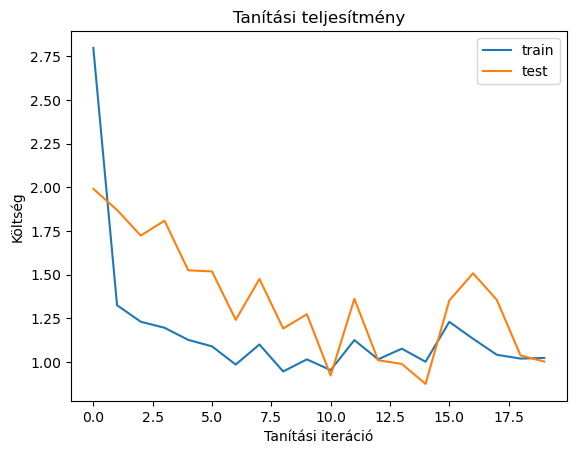

In [17]:
# Hálózat tanítása
history = model.fit(X_train, y_train, epochs=20, batch_size=70, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Tanítási statisztika kiíratása
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Tanítási teljesítmény')
plt.ylabel('Költség')
plt.xlabel('Tanítási iteráció')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Predikció

117/117 [==============================] - 1s 1ms/step
RMSE: 1.001187250376571


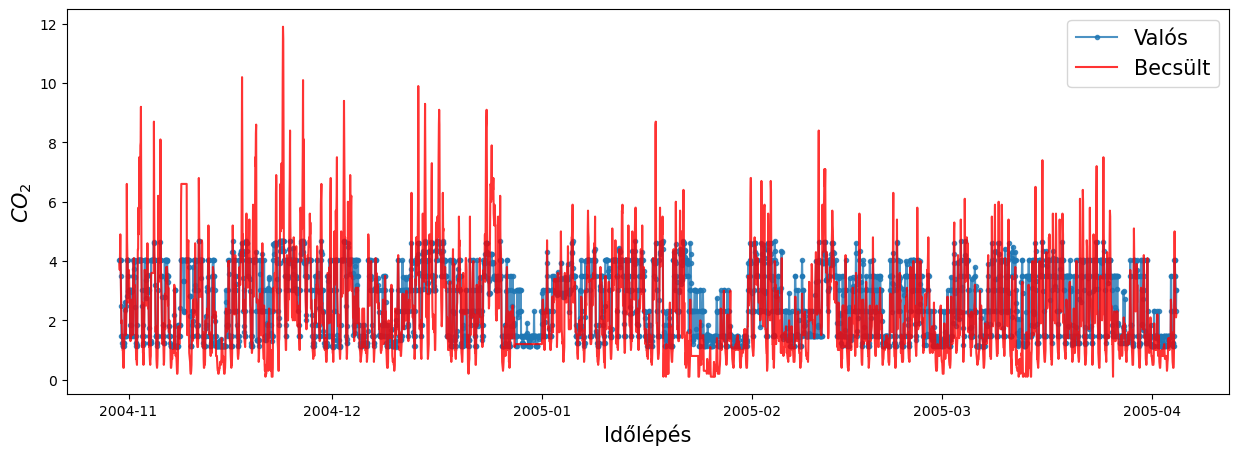

In [18]:
# Predikció a modellel
y_pred = model.predict(X_test)

# RMSE kiszámítása
rmse = np.sqrt(mean_squared_error(y_pred, y_test))

print('RMSE:', rmse)
plt.figure(figsize=(15, 5))
plt.plot(list(df.index)[train_time:], y_pred, marker='.', label="Valós", alpha=0.8)
plt.plot(list(df.index)[train_time:], y_test, 'r', label="Becsült", alpha=0.8)
plt.ylabel('$CO_2$', size=15)
plt.xlabel('Időlépés', size=15)
plt.legend(fontsize=15)
plt.show()